In [259]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
import os
import imageio
from torch.utils.data import TensorDataset
import cv2


In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 97861814.76it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50305520.69it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27066584.99it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9645837.35it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:

class VQ_VAE(nn.Module):
    def __init__(self, input_channels, QV_size):
        super(VQ_VAE, self).__init__()
        self.QV_size = QV_size
        self.conv_layers = nn.Sequential(
             nn.Conv2d(in_channels=input_channels, out_channels=128, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.Conv2d(in_channels=128, out_channels=QV_size, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             
                 )

        self.residual_block1 = self.residual_block()
        self.residual_block2 = self.residual_block()
        self.residual_block3 = self.residual_block()
        self.residual_block4 = self.residual_block()

        self.embedding_space = nn.Parameter(torch.Tensor([[2.0572, 0.6853],[0.5922, 0.6406],[1.6915, 1.9195]]))

        self.deconv_layers = nn.Sequential(
             nn.ConvTranspose2d(in_channels=QV_size, out_channels=128, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(in_channels=128, out_channels=input_channels, kernel_size=4, stride=2, padding=1),
             nn.ReLU()
                 )

    def residual_block(self):
        res_block = nn.Sequential(
                nn.Conv2d(in_channels=self.QV_size, out_channels=self.QV_size, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=self.QV_size, out_channels=self.QV_size, kernel_size=1, stride=1, padding=0),
                nn.ReLU()
                    )
        return res_block

    def forward(self, x):
        embed_space = self.embedding_space
        x = self.conv_layers(x)
        x = self.residual_block1(x) + x
        z_e = self.residual_block2(x) + x
        z_e_reshaped = z_e.view(z_e.size(0)*z_e.size(2)*z_e.size(3),z_e.size(1))
        distances = torch.cdist (z_e_reshaped, self.embedding_space)
        indices = torch.argmin (distances, dim=1) 
        z_q = self.embedding_space [indices]
        z_q = z_q.view(z_e.size())
        y = z_e + (z_q - z_e).detach()
        y = self.residual_block3(y) + y
        y = self.residual_block4(y) + y
        y = self.deconv_layers(y)
        return y,z_e,z_q,embed_space


In [6]:

def VQ_VAE_loss(y,x,z_e,z_q):
    x = x.view(x.size(0),-1)
    y = y.view(y.size(0),-1)
    
    mse_loss1 = nn.MSELoss()
    mse_loss2 = nn.MSELoss()
    mse_loss3 = nn.MSELoss() 

    reconstruction_loss = mse_loss1(y, x)
    """
    distances1 = torch.cdist(z_e.detach(), z_q)
    squared_distances1 = torch.pow(distances1, 2)
    codebook_loss = torch.sum(squared_distances1)
    distances2 = torch.cdist(z_e, z_q.detach())
    squared_distances2 = torch.pow(distances2, 2)
    commitment_loss = torch.sum(squared_distances2)
    """
    codebook_loss = mse_loss2(z_e.detach(), z_q)
    commitment_loss = mse_loss3(z_e, z_q.detach())
    total_loss = reconstruction_loss + codebook_loss + 0.3*commitment_loss
    return total_loss

    

In [7]:
def train(model, train_loader, device, num_epochs=15, learning_rate=0.0002):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    Loss_train=[]
    embeding_vector = []
    embeding_space = []
    for epoch in range(num_epochs):
        epoch_training_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)
            y,z_e,z_q,e = model(data)
            loss = VQ_VAE_loss(y,data,z_e,z_q)
            loss.backward()
            optimizer.step()
            epoch_training_loss += (loss.item())/128 
            embeding_space.append(e)
        embeding_vector.append(embeding_space)
        Loss_train.append(epoch_training_loss)
        print(f"Epoch {epoch+1} - Train Loss: {epoch_training_loss:.4f}")
    return embeding_vector
    





In [8]:
model3 = VQ_VAE(1,2)
model3 = nn.DataParallel(model3, device_ids=[0, 1])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model3 = model3.to(device)

In [9]:
embedding_space = train(model3,train_loader,device)

Epoch 1 - Train Loss: 0.2250
Epoch 2 - Train Loss: 0.2191
Epoch 3 - Train Loss: 0.2206
Epoch 4 - Train Loss: 0.2224
Epoch 5 - Train Loss: 0.2243
Epoch 6 - Train Loss: 0.2268
Epoch 7 - Train Loss: 0.2263
Epoch 8 - Train Loss: 0.2232
Epoch 9 - Train Loss: 0.2186
Epoch 10 - Train Loss: 0.2114
Epoch 11 - Train Loss: 0.2019
Epoch 12 - Train Loss: 0.1883
Epoch 13 - Train Loss: 0.1787
Epoch 14 - Train Loss: 0.1690
Epoch 15 - Train Loss: 0.1624


In [76]:
Loss_train = [0.2250,0.2191,0.2206,0.2224,0.2243,0.2268,0.2263,0.2232,0.2186,0.2114,0.2019,0.1883,0.1787,0.1690,0.1623]

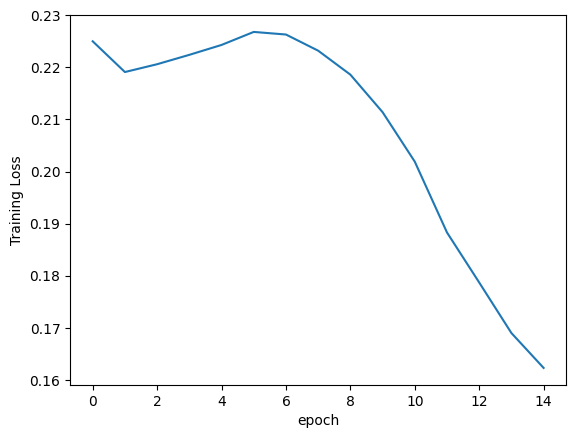

In [78]:
plt.plot(Loss_train)
plt.xlabel('epoch') 
plt.ylabel('Training Loss') 
plt.show()

In [12]:
def output_capture(model, data, device):
    data = data.to(device)
    with torch.no_grad():
        y,z_e,z_q,e = model(data)
    return y,z_e,z_q,e


In [13]:
img1 = train_dataset[25][0]
img2 = train_dataset[240][0]
img3 = train_dataset[410][0]
img4 = train_dataset[1200][0]
img5 = train_dataset[2200][0]
sample_dataset = torch.cat([img1, img2, img3, img4, img5])
sample_dataset = sample_dataset.unsqueeze(1)
print(sample_dataset.size())

torch.Size([5, 1, 28, 28])


In [14]:
y,z_e,z_q,e = output_capture(model3,sample_dataset,device)

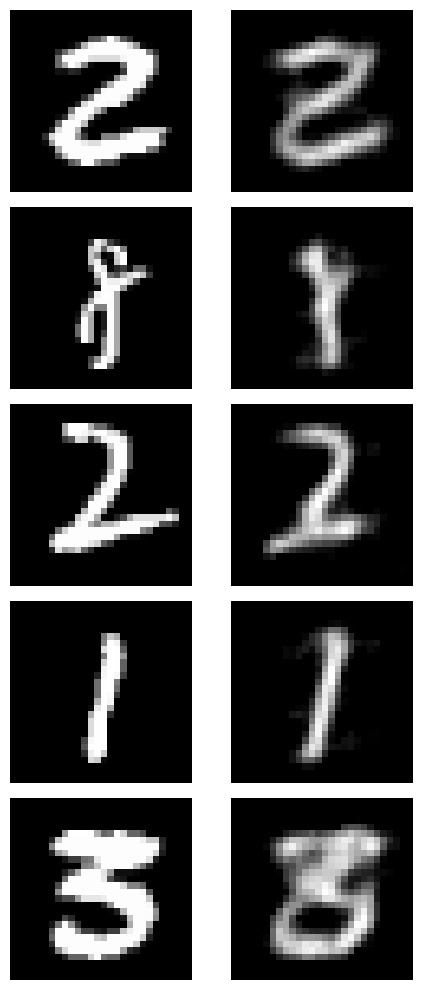

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(5, 10))

for i in range(5):
    image_tensor = sample_dataset[i].squeeze()
    image_array = image_tensor.numpy()
    axs[i, 0].imshow(image_array,cmap='gray')
    axs[i, 0].axis('off')
    out = y[i].squeeze()
    out_c = out.cpu()
    out_c = out_c.numpy()
    axs[i, 1].imshow(out_c,cmap='gray')
    axs[i, 1].axis('off')

plt.tight_layout()

plt.show()

In [68]:
embedding_vector1 = torch.zeros((30,2))
embedding_vector2 = torch.zeros((30,2))
embedding_vector3 = torch.zeros((30,2))

for i in range(30):
    embedding_vector1[i] = embedding_space[1][i*100][0]
    embedding_vector2[i] = embedding_space[1][i*100][1]
    embedding_vector3[i] = embedding_space[1][i*100][2]

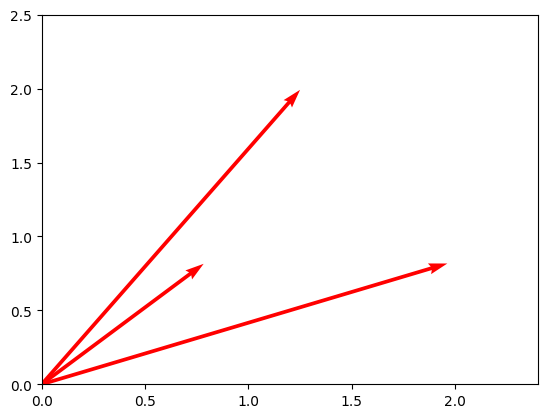

In [96]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.set_xlim(0, 2.4)
ax.set_ylim(0, 1)
for i in range(30):
    ax.clear()
    ax.set_xlim(0, 2.4)
    ax.set_ylim(0, 2.5)
    ax.quiver(0, 0, embedding_vector1[i][0].detach(), embedding_vector1[i][1].detach(), angles='xy', scale_units='xy', scale=1, color='r', label=f'Vector {i+1}')
    ax.quiver(0, 0, embedding_vector2[i][0].detach(), embedding_vector2[i][1].detach(), angles='xy', scale_units='xy', scale=1, color='r', label=f'Vector {i+1}')
    ax.quiver(0, 0, embedding_vector3[i][0].detach(), embedding_vector3[i][1].detach(), angles='xy', scale_units='xy', scale=1, color='r', label=f'Vector {i+1}')
    filename =  f'/kaggle/working/vector_plot_{i+1}.png'
    plt.savefig(filename)


In [103]:
img_list = []
for i in range(30):
    x = cv2.imread(f'/kaggle/working/vector_plot_{i+1}.png')
    img_list.append(x)

In [119]:
image_list = img_list 
output_path = '/kaggle/working/animation.gif'
pil_images = [Image.fromarray(np.uint8(image)) for image in image_list]
pil_images[0].save(output_path, save_all=True, append_images=pil_images[1:], optimize=False, duration=200, loop=0)

Animated GIF created successfully at: /kaggle/working/animation.gif


In [122]:
!cd /kaggle/working
from IPython.display import FileLink
FileLink('animation.gif')

/kaggle/working/animation.gif

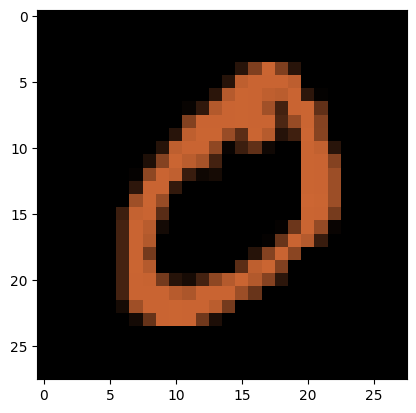

In [199]:
x1 = np.squeeze(train_dataset[1][0]) * 0.8
x2 = np.squeeze(train_dataset[1][0]) * 0.4
x3 = np.squeeze(train_dataset[1][0]) * 0.2
rgb_image = np.zeros((28,28,3))
rgb_image[:,:,0] = x1
rgb_image[:,:,1] = x2
rgb_image[:,:,2] = x3
plt.imshow(rgb_image)

In [211]:
rgb_dataset = torch.zeros(60000,3,28,28)
for i in range(60000):
    random_number = random.random()
    x1 = np.squeeze(train_dataset[i][0]) * random_number
    random_number = random.random()
    x2 = np.squeeze(train_dataset[i][0]) * random_number
    random_number = random.random()
    x3 = np.squeeze(train_dataset[i][0]) * random_number
    rgb_dataset[i][0]
    rgb_image = np.zeros((28,28,3))
    rgb_image[:,:,0] = x1
    rgb_image[:,:,1] = x2
    rgb_image[:,:,2] = x3
    tensor = transform(rgb_image)
    rgb_dataset[i] = tensor
    
    

In [236]:
#dataset_rgb = TensorDataset(rgb_dataset)
train_loader_rgb = DataLoader(rgb_dataset, batch_size=128, shuffle=True)

In [240]:
def train_rgb(model_r1, train_loader_rgb, device, num_epochs=15, learning_rate=0.0002):
    model_r1.train()
    optimizer = optim.Adam(model_r1.parameters(), lr=learning_rate)
    Loss_train=[]
    for epoch in range(num_epochs):
        epoch_training_loss = 0
        for batch_idx,data in enumerate(train_loader_rgb):
            optimizer.zero_grad()
            data = data.to(device)
            y,z_e,z_q,e = model_r1(data)
            loss = VQ_VAE_loss(y,data,z_e,z_q)
            loss.backward()
            optimizer.step()
            epoch_training_loss += (loss.item())/128 
        Loss_train.append(epoch_training_loss)
        print(f"Epoch {epoch+1} - Train Loss: {epoch_training_loss:.4f}")



In [241]:
model_r1 = VQ_VAE(3,2)
model_r1 = nn.DataParallel(model_r1, device_ids=[0, 1])
model_r1 = model_r1.to(device)

In [242]:
e = train_rgb(model_r1,train_loader_rgb,device)

Epoch 1 - Train Loss: 0.1780
Epoch 2 - Train Loss: 0.1749
Epoch 3 - Train Loss: 0.1586
Epoch 4 - Train Loss: 0.1533
Epoch 5 - Train Loss: 0.1523
Epoch 6 - Train Loss: 0.1519
Epoch 7 - Train Loss: 0.1529
Epoch 8 - Train Loss: 0.1541
Epoch 9 - Train Loss: 0.1550
Epoch 10 - Train Loss: 0.1555
Epoch 11 - Train Loss: 0.1560
Epoch 12 - Train Loss: 0.1566
Epoch 13 - Train Loss: 0.1569
Epoch 14 - Train Loss: 0.1574
Epoch 15 - Train Loss: 0.1577


In [249]:
rgbimg1 = rgb_dataset[25]
rgbimg2 = rgb_dataset[240]
rgbimg3 = rgb_dataset[410]
rgbimg4 = rgb_dataset[1200]
rgbimg5 = rgb_dataset[2200]
rgbsample_dataset = torch.stack((rgbimg1, rgbimg2, rgbimg3, rgbimg4, rgbimg5),dim=0)
print(rgbsample_dataset.size())
y,z_e,z_q,e = output_capture(model_r1,rgbsample_dataset,device)

torch.Size([5, 3, 28, 28])


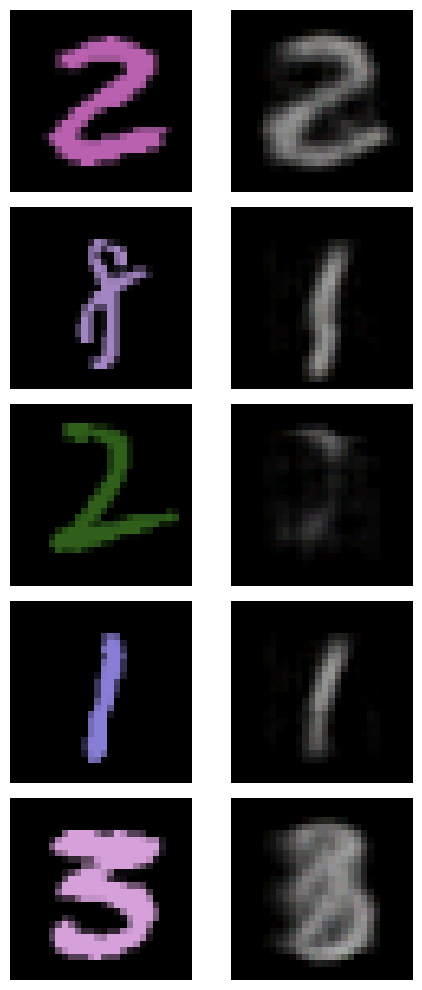

In [260]:
fig, axs = plt.subplots(5, 2, figsize=(5, 10))
for i in range(5):
    image_tensor = rgbsample_dataset[i]
    image_tensor = image_tensor.cpu()
    image_array = image_tensor.numpy().transpose(1, 2, 0) 
    image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    axs[i, 0].imshow(image_array)
    axs[i, 0].axis('off')
    out = y[i]
    out_c = out.cpu()
    out_c = out_c.numpy().transpose(1, 2, 0)
    out_c = cv2.cvtColor(out_c, cv2.COLOR_RGB2BGR)
    axs[i, 1].imshow(out_c)
    axs[i, 1].axis('off')

plt.tight_layout()

plt.show()

In [285]:

class VQ_VAE_e20(nn.Module):
    def __init__(self, input_channels, QV_size):
        super(VQ_VAE_e20, self).__init__()
        self.QV_size = QV_size
        self.conv_layers = nn.Sequential(
             nn.Conv2d(in_channels=input_channels, out_channels=128, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.Conv2d(in_channels=128, out_channels=QV_size, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             
                 )

        self.residual_block1 = self.residual_block()
        self.residual_block2 = self.residual_block()
        self.residual_block3 = self.residual_block()
        self.residual_block4 = self.residual_block()

        self.embedding_space = nn.Parameter(torch.randn(20,2))

        self.deconv_layers = nn.Sequential(
             nn.ConvTranspose2d(in_channels=QV_size, out_channels=128, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(in_channels=128, out_channels=input_channels, kernel_size=4, stride=2, padding=1),
             nn.ReLU()
                 )

    def residual_block(self):
        res_block = nn.Sequential(
                nn.Conv2d(in_channels=self.QV_size, out_channels=self.QV_size, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=self.QV_size, out_channels=self.QV_size, kernel_size=1, stride=1, padding=0),
                nn.ReLU()
                    )
        return res_block

    def forward(self, x):
        embed_space = self.embedding_space
        x = self.conv_layers(x)
        x = self.residual_block1(x) + x
        z_e = self.residual_block2(x) + x
        z_e_reshaped = z_e.view(z_e.size(0)*z_e.size(2)*z_e.size(3),z_e.size(1))
        distances = torch.cdist (z_e_reshaped, self.embedding_space)
        indices = torch.argmin (distances, dim=1) 
        z_q = self.embedding_space [indices]
        z_q = z_q.view(z_e.size())
        y = z_e + (z_q - z_e).detach()
        y = self.residual_block3(y) + y
        y = self.residual_block4(y) + y
        y = self.deconv_layers(y)
        return y,z_e,z_q,embed_space


In [289]:
model_e1 = VQ_VAE_e20(3,2)
model_e1 = nn.DataParallel(model_e1, device_ids=[0, 1])
model_e1 = model_e1.to(device)

In [290]:

train_rgb(model_e1,train_loader_rgb,device)

Epoch 1 - Train Loss: 0.2393
Epoch 2 - Train Loss: 0.2305
Epoch 3 - Train Loss: 0.1248
Epoch 4 - Train Loss: 0.0977
Epoch 5 - Train Loss: 0.0864
Epoch 6 - Train Loss: 0.0835
Epoch 7 - Train Loss: 0.0830
Epoch 8 - Train Loss: 0.0832
Epoch 9 - Train Loss: 0.0851
Epoch 10 - Train Loss: 0.0750
Epoch 11 - Train Loss: 0.0681
Epoch 12 - Train Loss: 0.0644
Epoch 13 - Train Loss: 0.0647
Epoch 14 - Train Loss: 0.0648
Epoch 15 - Train Loss: 0.0649


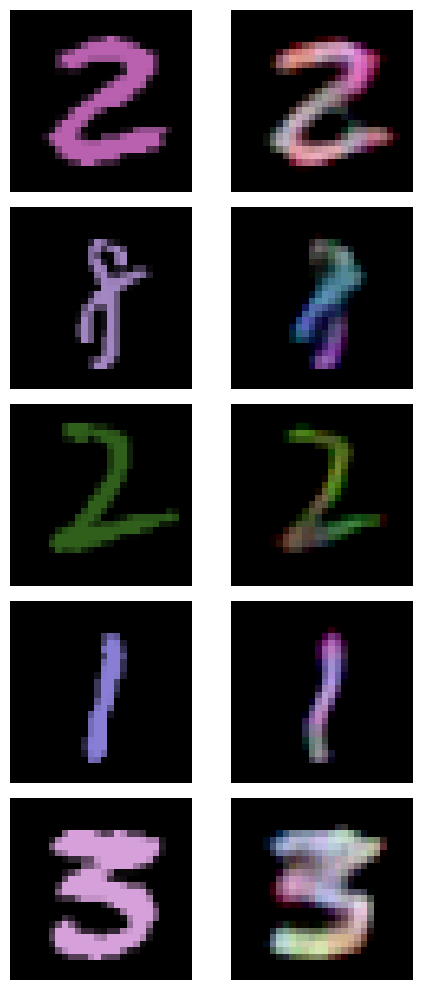

In [291]:
y,z_e,z_q,e = output_capture(model_e1,rgbsample_dataset,device)
fig, axs = plt.subplots(5, 2, figsize=(5, 10))
for i in range(5):
    image_tensor = rgbsample_dataset[i]
    image_tensor = image_tensor.cpu()
    image_array = image_tensor.numpy().transpose(1, 2, 0) 
    image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    axs[i, 0].imshow(image_array)
    axs[i, 0].axis('off')
    out = y[i]
    out_c = out.cpu()
    out_c = out_c.numpy().transpose(1, 2, 0)
    out_c = cv2.cvtColor(out_c, cv2.COLOR_RGB2BGR)
    axs[i, 1].imshow(out_c)
    axs[i, 1].axis('off')

plt.tight_layout()

plt.show()

In [295]:

class VQ_VAE_e40(nn.Module):
    def __init__(self, input_channels, QV_size):
        super(VQ_VAE_e40, self).__init__()
        self.QV_size = QV_size
        self.conv_layers = nn.Sequential(
             nn.Conv2d(in_channels=input_channels, out_channels=128, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.Conv2d(in_channels=128, out_channels=QV_size, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             
                 )

        self.residual_block1 = self.residual_block()
        self.residual_block2 = self.residual_block()
        self.residual_block3 = self.residual_block()
        self.residual_block4 = self.residual_block()

        self.embedding_space = nn.Parameter(torch.randn(40,2))

        self.deconv_layers = nn.Sequential(
             nn.ConvTranspose2d(in_channels=QV_size, out_channels=128, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(in_channels=128, out_channels=input_channels, kernel_size=4, stride=2, padding=1),
             nn.ReLU()
                 )

    def residual_block(self):
        res_block = nn.Sequential(
                nn.Conv2d(in_channels=self.QV_size, out_channels=self.QV_size, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=self.QV_size, out_channels=self.QV_size, kernel_size=1, stride=1, padding=0),
                nn.ReLU()
                    )
        return res_block

    def forward(self, x):
        embed_space = self.embedding_space
        x = self.conv_layers(x)
        x = self.residual_block1(x) + x
        z_e = self.residual_block2(x) + x
        z_e_reshaped = z_e.view(z_e.size(0)*z_e.size(2)*z_e.size(3),z_e.size(1))
        distances = torch.cdist (z_e_reshaped, self.embedding_space)
        indices = torch.argmin (distances, dim=1) 
        z_q = self.embedding_space [indices]
        z_q = z_q.view(z_e.size())
        y = z_e + (z_q - z_e).detach()
        y = self.residual_block3(y) + y
        y = self.residual_block4(y) + y
        y = self.deconv_layers(y)
        return y,z_e,z_q,embed_space


In [296]:
model_e2 = VQ_VAE_e40(3,2)
model_e2 = nn.DataParallel(model_e2, device_ids=[0, 1])
model_e2 = model_e2.to(device)


In [297]:
train_rgb(model_e2,train_loader_rgb,device)

Epoch 1 - Train Loss: 0.1221
Epoch 2 - Train Loss: 0.0990
Epoch 3 - Train Loss: 0.0941
Epoch 4 - Train Loss: 0.0914
Epoch 5 - Train Loss: 0.0901
Epoch 6 - Train Loss: 0.0892
Epoch 7 - Train Loss: 0.0839
Epoch 8 - Train Loss: 0.0778
Epoch 9 - Train Loss: 0.0743
Epoch 10 - Train Loss: 0.0721
Epoch 11 - Train Loss: 0.0700
Epoch 12 - Train Loss: 0.0687
Epoch 13 - Train Loss: 0.0680
Epoch 14 - Train Loss: 0.0675
Epoch 15 - Train Loss: 0.0671


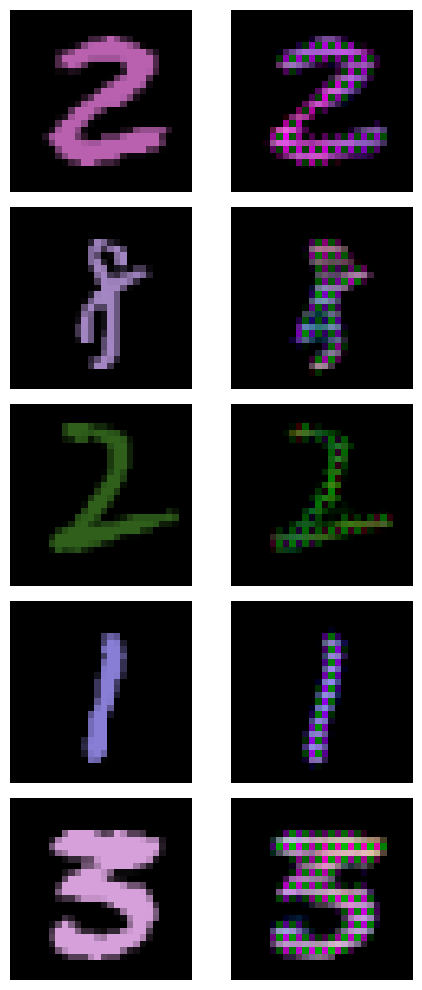

In [298]:
y,z_e,z_q,e = output_capture(model_e2,rgbsample_dataset,device)
fig, axs = plt.subplots(5, 2, figsize=(5, 10))
for i in range(5):
    image_tensor = rgbsample_dataset[i]
    image_tensor = image_tensor.cpu()
    image_array = image_tensor.numpy().transpose(1, 2, 0) 
    image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    axs[i, 0].imshow(image_array)
    axs[i, 0].axis('off')
    out = y[i]
    out_c = out.cpu()
    out_c = out_c.numpy().transpose(1, 2, 0)
    out_c = cv2.cvtColor(out_c, cv2.COLOR_RGB2BGR)
    axs[i, 1].imshow(out_c)
    axs[i, 1].axis('off')

plt.tight_layout()

plt.show()

In [271]:

class VQ_VAE_20(nn.Module):
    def __init__(self, input_channels, QV_size):
        super(VQ_VAE_20, self).__init__()
        self.QV_size = QV_size
        self.conv_layers = nn.Sequential(
             nn.Conv2d(in_channels=input_channels, out_channels=128, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.Conv2d(in_channels=128, out_channels=QV_size, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             
                 )

        self.residual_block1 = self.residual_block()
        self.residual_block2 = self.residual_block()
        self.residual_block3 = self.residual_block()
        self.residual_block4 = self.residual_block()

        self.embedding_space = nn.Parameter(torch.randn(3,20))

        self.deconv_layers = nn.Sequential(
             nn.ConvTranspose2d(in_channels=QV_size, out_channels=128, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(in_channels=128, out_channels=input_channels, kernel_size=4, stride=2, padding=1),
             nn.ReLU()
                 )

    def residual_block(self):
        res_block = nn.Sequential(
                nn.Conv2d(in_channels=self.QV_size, out_channels=self.QV_size, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=self.QV_size, out_channels=self.QV_size, kernel_size=1, stride=1, padding=0),
                nn.ReLU()
                    )
        return res_block

    def forward(self, x):
        embed_space = self.embedding_space
        x = self.conv_layers(x)
        x = self.residual_block1(x) + x
        z_e = self.residual_block2(x) + x
        z_e_reshaped = z_e.view(z_e.size(0)*z_e.size(2)*z_e.size(3),z_e.size(1))
        distances = torch.cdist (z_e_reshaped, self.embedding_space)
        indices = torch.argmin (distances, dim=1) 
        z_q = self.embedding_space [indices]
        z_q = z_q.view(z_e.size())
        y = z_e + (z_q - z_e).detach()
        y = self.residual_block3(y) + y
        y = self.residual_block4(y) + y
        y = self.deconv_layers(y)
        return y,z_e,z_q,embed_space


In [272]:
model_r2 = VQ_VAE_20(3,20)
model_r2 = nn.DataParallel(model_r2, device_ids=[0, 1])
model_r2 = model_r2.to(device)

In [275]:
train_rgb(model_r2,train_loader_rgb,device)

Epoch 1 - Train Loss: 0.2192
Epoch 2 - Train Loss: 0.1895
Epoch 3 - Train Loss: 0.1690
Epoch 4 - Train Loss: 0.1558
Epoch 5 - Train Loss: 0.1465
Epoch 6 - Train Loss: 0.1405
Epoch 7 - Train Loss: 0.1371
Epoch 8 - Train Loss: 0.1357
Epoch 9 - Train Loss: 0.1354
Epoch 10 - Train Loss: 0.1355
Epoch 11 - Train Loss: 0.1358
Epoch 12 - Train Loss: 0.1363
Epoch 13 - Train Loss: 0.1368
Epoch 14 - Train Loss: 0.1368
Epoch 15 - Train Loss: 0.1367


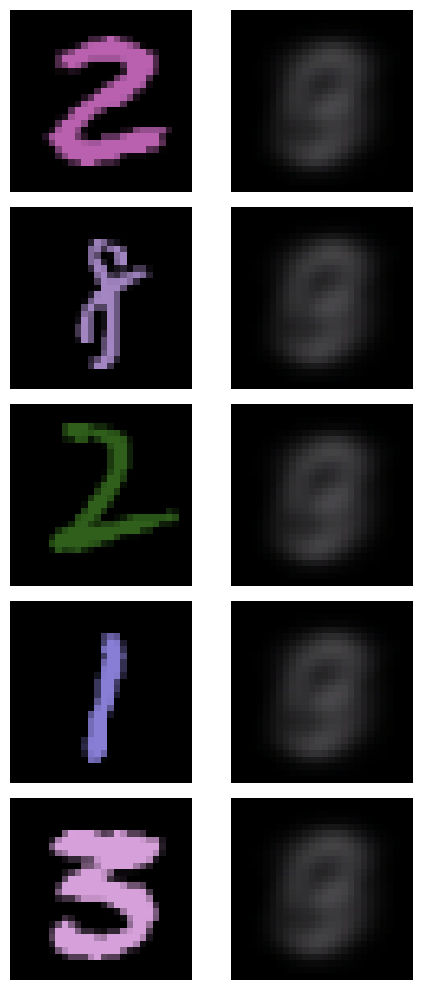

In [276]:
y,z_e,z_q,e = output_capture(model_r2,rgbsample_dataset,device)
fig, axs = plt.subplots(5, 2, figsize=(5, 10))
for i in range(5):
    image_tensor = rgbsample_dataset[i]
    image_tensor = image_tensor.cpu()
    image_array = image_tensor.numpy().transpose(1, 2, 0) 
    image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    axs[i, 0].imshow(image_array)
    axs[i, 0].axis('off')
    out = y[i]
    out_c = out.cpu()
    out_c = out_c.numpy().transpose(1, 2, 0)
    out_c = cv2.cvtColor(out_c, cv2.COLOR_RGB2BGR)
    axs[i, 1].imshow(out_c)
    axs[i, 1].axis('off')

plt.tight_layout()

plt.show()

In [278]:

class VQ_VAE_40(nn.Module):
    def __init__(self, input_channels, QV_size):
        super(VQ_VAE_40, self).__init__()
        self.QV_size = QV_size
        self.conv_layers = nn.Sequential(
             nn.Conv2d(in_channels=input_channels, out_channels=128, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.Conv2d(in_channels=128, out_channels=QV_size, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             
                 )

        self.residual_block1 = self.residual_block()
        self.residual_block2 = self.residual_block()
        self.residual_block3 = self.residual_block()
        self.residual_block4 = self.residual_block()

        self.embedding_space = nn.Parameter(torch.randn(3,40))

        self.deconv_layers = nn.Sequential(
             nn.ConvTranspose2d(in_channels=QV_size, out_channels=128, kernel_size=4, stride=2, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(in_channels=128, out_channels=input_channels, kernel_size=4, stride=2, padding=1),
             nn.ReLU()
                 )

    def residual_block(self):
        res_block = nn.Sequential(
                nn.Conv2d(in_channels=self.QV_size, out_channels=self.QV_size, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=self.QV_size, out_channels=self.QV_size, kernel_size=1, stride=1, padding=0),
                nn.ReLU()
                    )
        return res_block

    def forward(self, x):
        embed_space = self.embedding_space
        x = self.conv_layers(x)
        x = self.residual_block1(x) + x
        z_e = self.residual_block2(x) + x
        z_e_reshaped = z_e.view(z_e.size(0)*z_e.size(2)*z_e.size(3),z_e.size(1))
        distances = torch.cdist (z_e_reshaped, self.embedding_space)
        indices = torch.argmin (distances, dim=1) 
        z_q = self.embedding_space [indices]
        z_q = z_q.view(z_e.size())
        y = z_e + (z_q - z_e).detach()
        y = self.residual_block3(y) + y
        y = self.residual_block4(y) + y
        y = self.deconv_layers(y)
        return y,z_e,z_q,embed_space


In [279]:
model_r3 = VQ_VAE_40(3,40)
model_r3 = nn.DataParallel(model_r3, device_ids=[0, 1])
model_r3 = model_r3.to(device)
train_rgb(model_r3,train_loader_rgb,device)

Epoch 1 - Train Loss: 3.6257
Epoch 2 - Train Loss: 2.6617
Epoch 3 - Train Loss: 2.2683
Epoch 4 - Train Loss: 1.9690
Epoch 5 - Train Loss: 1.7202
Epoch 6 - Train Loss: 1.5056
Epoch 7 - Train Loss: 1.3157
Epoch 8 - Train Loss: 1.1463
Epoch 9 - Train Loss: 0.9959
Epoch 10 - Train Loss: 0.8654
Epoch 11 - Train Loss: 0.7519
Epoch 12 - Train Loss: 0.6523
Epoch 13 - Train Loss: 0.5671
Epoch 14 - Train Loss: 0.4939
Epoch 15 - Train Loss: 0.4328


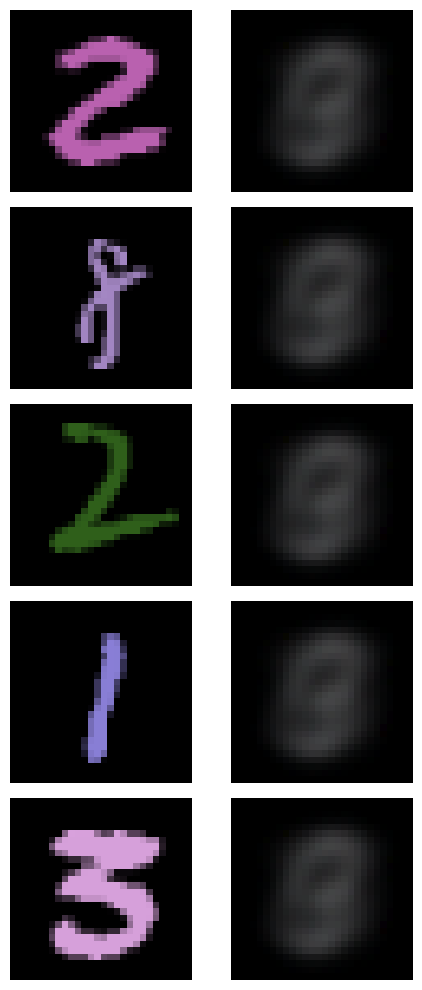

In [280]:
y,z_e,z_q,e = output_capture(model_r3,rgbsample_dataset,device)
fig, axs = plt.subplots(5, 2, figsize=(5, 10))
for i in range(5):
    image_tensor = rgbsample_dataset[i]
    image_tensor = image_tensor.cpu()
    image_array = image_tensor.numpy().transpose(1, 2, 0) 
    image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    axs[i, 0].imshow(image_array)
    axs[i, 0].axis('off')
    out = y[i]
    out_c = out.cpu()
    out_c = out_c.numpy().transpose(1, 2, 0)
    out_c = cv2.cvtColor(out_c, cv2.COLOR_RGB2BGR)
    axs[i, 1].imshow(out_c)
    axs[i, 1].axis('off')

plt.tight_layout()

plt.show()